In [1]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path

import tqdm
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.semi_supervised import LabelSpreading, LabelPropagation, SelfTrainingClassifier
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import EnsembleVoteClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_pickle('data/chkp3.pkl')
df['category_id'] = df.category_id.astype(np.int16)
mask = pd.read_pickle('data/known_unknown_mask.pkl')

#### Wczytywanie danych

In [3]:
unknown_df = df.copy()

unknown_df.loc[~mask, 'category_id'] = -1
unknown_df.category_id.value_counts(dropna=False)[:5]

-1     5768
 24     684
 10     608
 22     241
 23     220
Name: category_id, dtype: int64

In [4]:
X_df = unknown_df.drop('category_id', axis=1)
y_df = unknown_df['category_id']
y_true_df = df.category_id

# Punkt odniesienia

Uwzględniając cały zbiór danych mamy znane około 33% kategorii.

In [5]:
print(f'Accuracy: {accuracy_score(y_true_df, y_df)}')

Accuracy: 0.32976992795723914


W przypadku zbioru `X_unkwn` widać, że nie znamy kategorii dla tego zbioru.

In [6]:
unknown_df['category_id_truth'] = df.category_id
temp_df = unknown_df[~mask]
X_unkwn, y_unkwn = temp_df.drop(['category_id', 'category_id_truth'], axis=1), temp_df.category_id_truth

print(f'Accuracy: {accuracy_score(temp_df.category_id, y_unkwn)}')

Accuracy: 0.0


## Regresja logistyczna jako punkt odniesienia

In [7]:
clf_dir = Path('data/chkp3')

def fit_score(clf, X, y, verbose=False):
    file_name = joblib.hash(str(clf)) + ".pkl"
    clf_path = clf_dir / file_name
    if clf_path.exists():
        clf = joblib.load(clf_path)
        if verbose:
            print(f"Loading from {clf_path}")
    else:
        clf.fit(X, y)
        joblib.dump(clf, str(clf_path))
        if verbose:
            print(f"Saving to {clf_path}")
            
    y_hat = clf.predict(X_df)
    y_kwn_hat = clf.predict(X_kwn)
    y_unkwn_hat = clf.predict(X_unkwn)
    
    return {
        'name': str(clf),
        
        'all_accuracy': accuracy_score(y_true_df, y_hat),
        'all_balanced_accuracy': balanced_accuracy_score(y_true_df, y_hat),
        
        'known_accuracy': accuracy_score(y_kwn, y_kwn_hat),
        'known_balanced_accuracy': balanced_accuracy_score(y_kwn, y_kwn_hat),
        
        'unknown_accuracy': accuracy_score(y_unkwn, y_unkwn_hat),
        'unknown_balanced_accuracy': balanced_accuracy_score(y_unkwn, y_unkwn_hat)
    }

In [8]:
transformers = [RobustScaler(quantile_range=(5.0, 95.0)), StandardScaler(), Normalizer()]

In [9]:
df_known = unknown_df[unknown_df.category_id != -1]
X_kwn, y_kwn = df_known.drop(['category_id', 'category_id_truth'], axis=1), df_known.category_id_truth

clfs = [make_pipeline(t, LogisticRegression(max_iter=10000, random_state=42)) for t in transformers]
scores_lr = [fit_score(clf, X_kwn, y_kwn) for clf in tqdm.tqdm(clfs)]

scores_lr_df = pd.DataFrame.from_records(scores_lr).set_index('name').sort_values('unknown_accuracy', ascending=False)
scores_lr_df

100%|██████████| 3/3 [00:00<00:00,  8.61it/s]


,all_accuracy,all_balanced_accuracy,known_accuracy,known_balanced_accuracy,unknown_accuracy,unknown_balanced_accuracy
name,,,,,,
"Pipeline(steps=[('robustscaler', RobustScaler(quantile_range=(5.0, 95.0))),\n ('logisticregression',\n LogisticRegression(max_iter=10000, random_state=42))])",0.674181,0.634783,0.828048,0.869039,0.598474,0.506790
"Pipeline(steps=[('standardscaler', StandardScaler()),\n ('logisticregression',\n LogisticRegression(max_iter=10000, random_state=42))])",0.664769,0.636493,0.866808,0.915132,0.565361,0.487779
"Pipeline(steps=[('normalizer', Normalizer()),\n ('logisticregression',\n LogisticRegression(max_iter=10000, random_state=42))])",0.217058,0.066286,0.242424,0.067000,0.204577,0.069950


<AxesSubplot:ylabel='name'>

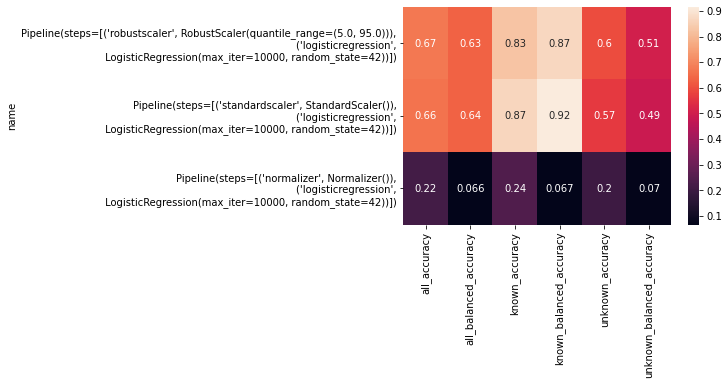

In [10]:
sns.heatmap(scores_lr_df, annot=True)

# Uczenie półnadzorowane

Zrezygonowaliśmy z LabelPropagation z jądrem RBF, ponieważ bardzo długo zajmuje jego uczenie (https://scikit-learn.org/stable/modules/semi_supervised.html#label-propagation).

In [11]:
propagations_max_iter = 1000
propagations = []
propagations += [LabelPropagation(kernel='rbf', 
                                  gamma=gamma, 
                                  max_iter=propagations_max_iter, 
                                  n_jobs=-1) for gamma in [0.5, 1, 5]]
propagations += [LabelPropagation(kernel='knn', 
                                  n_neighbors=k, 
                                  max_iter=propagations_max_iter, 
                                  n_jobs=-1) for k in [5, 7, 9]]
propagations

[LabelPropagation(gamma=0.5, n_jobs=-1),
 LabelPropagation(gamma=1, n_jobs=-1),
 LabelPropagation(gamma=5, n_jobs=-1),
 LabelPropagation(kernel='knn', n_jobs=-1, n_neighbors=5),
 LabelPropagation(kernel='knn', n_jobs=-1),
 LabelPropagation(kernel='knn', n_jobs=-1, n_neighbors=9)]

In [12]:
spreadings_max_iter = 100

spreadings = []
spreadings += [LabelSpreading(kernel='rbf', 
                              gamma=gamma, 
                              max_iter=spreadings_max_iter, 
                              tol=1e-3,
                              n_jobs=-1) for gamma in [0.5, 1, 5, 20]]
spreadings += [LabelSpreading(kernel='knn', 
                              n_neighbors=k, 
                              max_iter=spreadings_max_iter, 
                              n_jobs=-1) for k in [5, 7, 9]]
spreadings

[LabelSpreading(gamma=0.5, max_iter=100, n_jobs=-1),
 LabelSpreading(gamma=1, max_iter=100, n_jobs=-1),
 LabelSpreading(gamma=5, max_iter=100, n_jobs=-1),
 LabelSpreading(max_iter=100, n_jobs=-1),
 LabelSpreading(kernel='knn', max_iter=100, n_jobs=-1, n_neighbors=5),
 LabelSpreading(kernel='knn', max_iter=100, n_jobs=-1),
 LabelSpreading(kernel='knn', max_iter=100, n_jobs=-1, n_neighbors=9)]

In [13]:
self_trainings_max_iter = None
self_trainings_clfs = [
    SVC(kernel='rbf', gamma="auto", probability=True),
    LogisticRegression(max_iter=10000, random_state=42)
]
self_trainings_thresholds = [0.75, 0.8]

self_trainings_params = product(self_trainings_clfs, self_trainings_thresholds)
self_trainings = []
self_trainings += [SelfTrainingClassifier(clf, threshold=thresh, max_iter=self_trainings_max_iter) for clf, thresh in self_trainings_params]
self_trainings += [SelfTrainingClassifier(clf, criterion='k_best', max_iter=self_trainings_max_iter) for clf in self_trainings_clfs]
self_trainings

[SelfTrainingClassifier(base_estimator=SVC(gamma='auto', probability=True),
                        max_iter=None),
 SelfTrainingClassifier(base_estimator=SVC(gamma='auto', probability=True),
                        max_iter=None, threshold=0.8),
 SelfTrainingClassifier(base_estimator=LogisticRegression(max_iter=10000,
                                                          random_state=42),
                        max_iter=None),
 SelfTrainingClassifier(base_estimator=LogisticRegression(max_iter=10000,
                                                          random_state=42),
                        max_iter=None, threshold=0.8),
 SelfTrainingClassifier(base_estimator=SVC(gamma='auto', probability=True),
                        criterion='k_best', max_iter=None),
 SelfTrainingClassifier(base_estimator=LogisticRegression(max_iter=10000,
                                                          random_state=42),
                        criterion='k_best', max_iter=None)]

# Oceny klasyfikatorów

In [14]:
clfs = [make_pipeline(RobustScaler(quantile_range=(5., 95.)), clf) for clf in (propagations + spreadings + self_trainings)]
scores = [fit_score(clf, X_df, y_df, verbose=True) for clf in clfs]

scores_df = pd.DataFrame.from_records(scores).set_index('name').sort_values('unknown_accuracy', ascending=False)
scores_df

Loading from data/chkp3/1ce6e5bb276604c31dbce42f241c9e76.pkl
Loading from data/chkp3/64f128724265d6ce18d07d909290ab9d.pkl
Loading from data/chkp3/0fe24880878a6dc2268db55b3fa2698f.pkl
Loading from data/chkp3/544f1b514c399bcbbacca1cc34791a09.pkl
Loading from data/chkp3/6435542625094c58126cf8436a309b6f.pkl
Loading from data/chkp3/eb5f163b800a325d185a6a4ab5f2ee24.pkl
Loading from data/chkp3/d45585f1c2d9c7b3fc3d8c57594dc1d0.pkl
Loading from data/chkp3/a39caf8d0c47af67e1f9bce1ee1f719c.pkl
Loading from data/chkp3/e09e8da93069705c2c30f17069d39156.pkl
Loading from data/chkp3/9015a169ec67ce6331db832218bf500f.pkl
Loading from data/chkp3/198f38f8ed7d4ee81d85f85efabf2aa3.pkl
Loading from data/chkp3/7e13225676463d0f91b4e11094eeef4b.pkl
Loading from data/chkp3/eb541817712e12aa3213c6897f4bce31.pkl
Loading from data/chkp3/786aae8253bde7fb21972e67249534d1.pkl
Loading from data/chkp3/1cb164c11325df524c2a3dbae5a1632d.pkl
Loading from data/chkp3/d0d14594695179e0109f47c6b1f1c4b0.pkl
Loading from data/chkp3/

,all_accuracy,all_balanced_accuracy,known_accuracy,known_balanced_accuracy,unknown_accuracy,unknown_balanced_accuracy
name,,,,,,
"Pipeline(steps=[('robustscaler', RobustScaler(quantile_range=(5.0, 95.0))),\n ('selftrainingclassifier',\n SelfTrainingClassifier(base_estimator=LogisticRegression(max_iter=10000,\n random_state=42),\n max_iter=None, threshold=0.8))])",0.680339,0.635791,0.822410,0.852751,0.610437,0.515039
"Pipeline(steps=[('robustscaler', RobustScaler(quantile_range=(5.0, 95.0))),\n ('selftrainingclassifier',\n SelfTrainingClassifier(base_estimator=LogisticRegression(max_iter=10000,\n random_state=42),\n max_iter=None))])",0.679177,0.633634,0.819591,0.849324,0.610090,0.513164
"Pipeline(steps=[('robustscaler', RobustScaler(quantile_range=(5.0, 95.0))),\n ('selftrainingclassifier',\n SelfTrainingClassifier(base_estimator=LogisticRegression(max_iter=10000,\n random_state=42),\n criterion='k_best', max_iter=None))])",0.670114,0.608269,0.801621,0.801245,0.605409,0.495823
"Pipeline(steps=[('robustscaler', RobustScaler(quantile_range=(5.0, 95.0))),\n ('selftrainingclassifier',\n SelfTrainingClassifier(base_estimator=SVC(gamma='auto',\n probability=True),\n max_iter=None))])",0.584244,0.370757,0.624383,0.393718,0.564494,0.384135
"Pipeline(steps=[('robustscaler', RobustScaler(quantile_range=(5.0, 95.0))),\n ('selftrainingclassifier',\n SelfTrainingClassifier(base_estimator=SVC(gamma='auto',\n probability=True),\n max_iter=None, threshold=0.8))])",0.576458,0.348885,0.623679,0.379503,0.553225,0.356904
"Pipeline(steps=[('robustscaler', RobustScaler(quantile_range=(5.0, 95.0))),\n ('labelspreading',\n LabelSpreading(gamma=0.5, max_iter=100, n_jobs=-1))])",0.689287,0.598019,1.000000,1.000000,0.536408,0.383390
"Pipeline(steps=[('robustscaler', RobustScaler(quantile_range=(5.0, 95.0))),\n ('selftrainingclassifier',\n SelfTrainingClassifier(base_estimator=SVC(gamma='auto',\n probability=True),\n criterion='k_best', max_iter=None))])",0.552173,0.368001,0.588795,0.386798,0.534154,0.383126
"Pipeline(steps=[('robustscaler', RobustScaler(quantile_range=(5.0, 95.0))),\n ('labelspreading',\n LabelSpreading(kernel='knn', max_iter=100, n_jobs=-1,\n n_neighbors=9))])",0.572275,0.397401,0.681818,0.513480,0.518377,0.369008
"Pipeline(steps=[('robustscaler', RobustScaler(quantile_range=(5.0, 95.0))),\n ('labelspreading',\n LabelSpreading(gamma=1, max_iter=100, n_jobs=-1))])",0.677086,0.611422,1.000000,1.000000,0.518204,0.403629


<AxesSubplot:ylabel='name'>

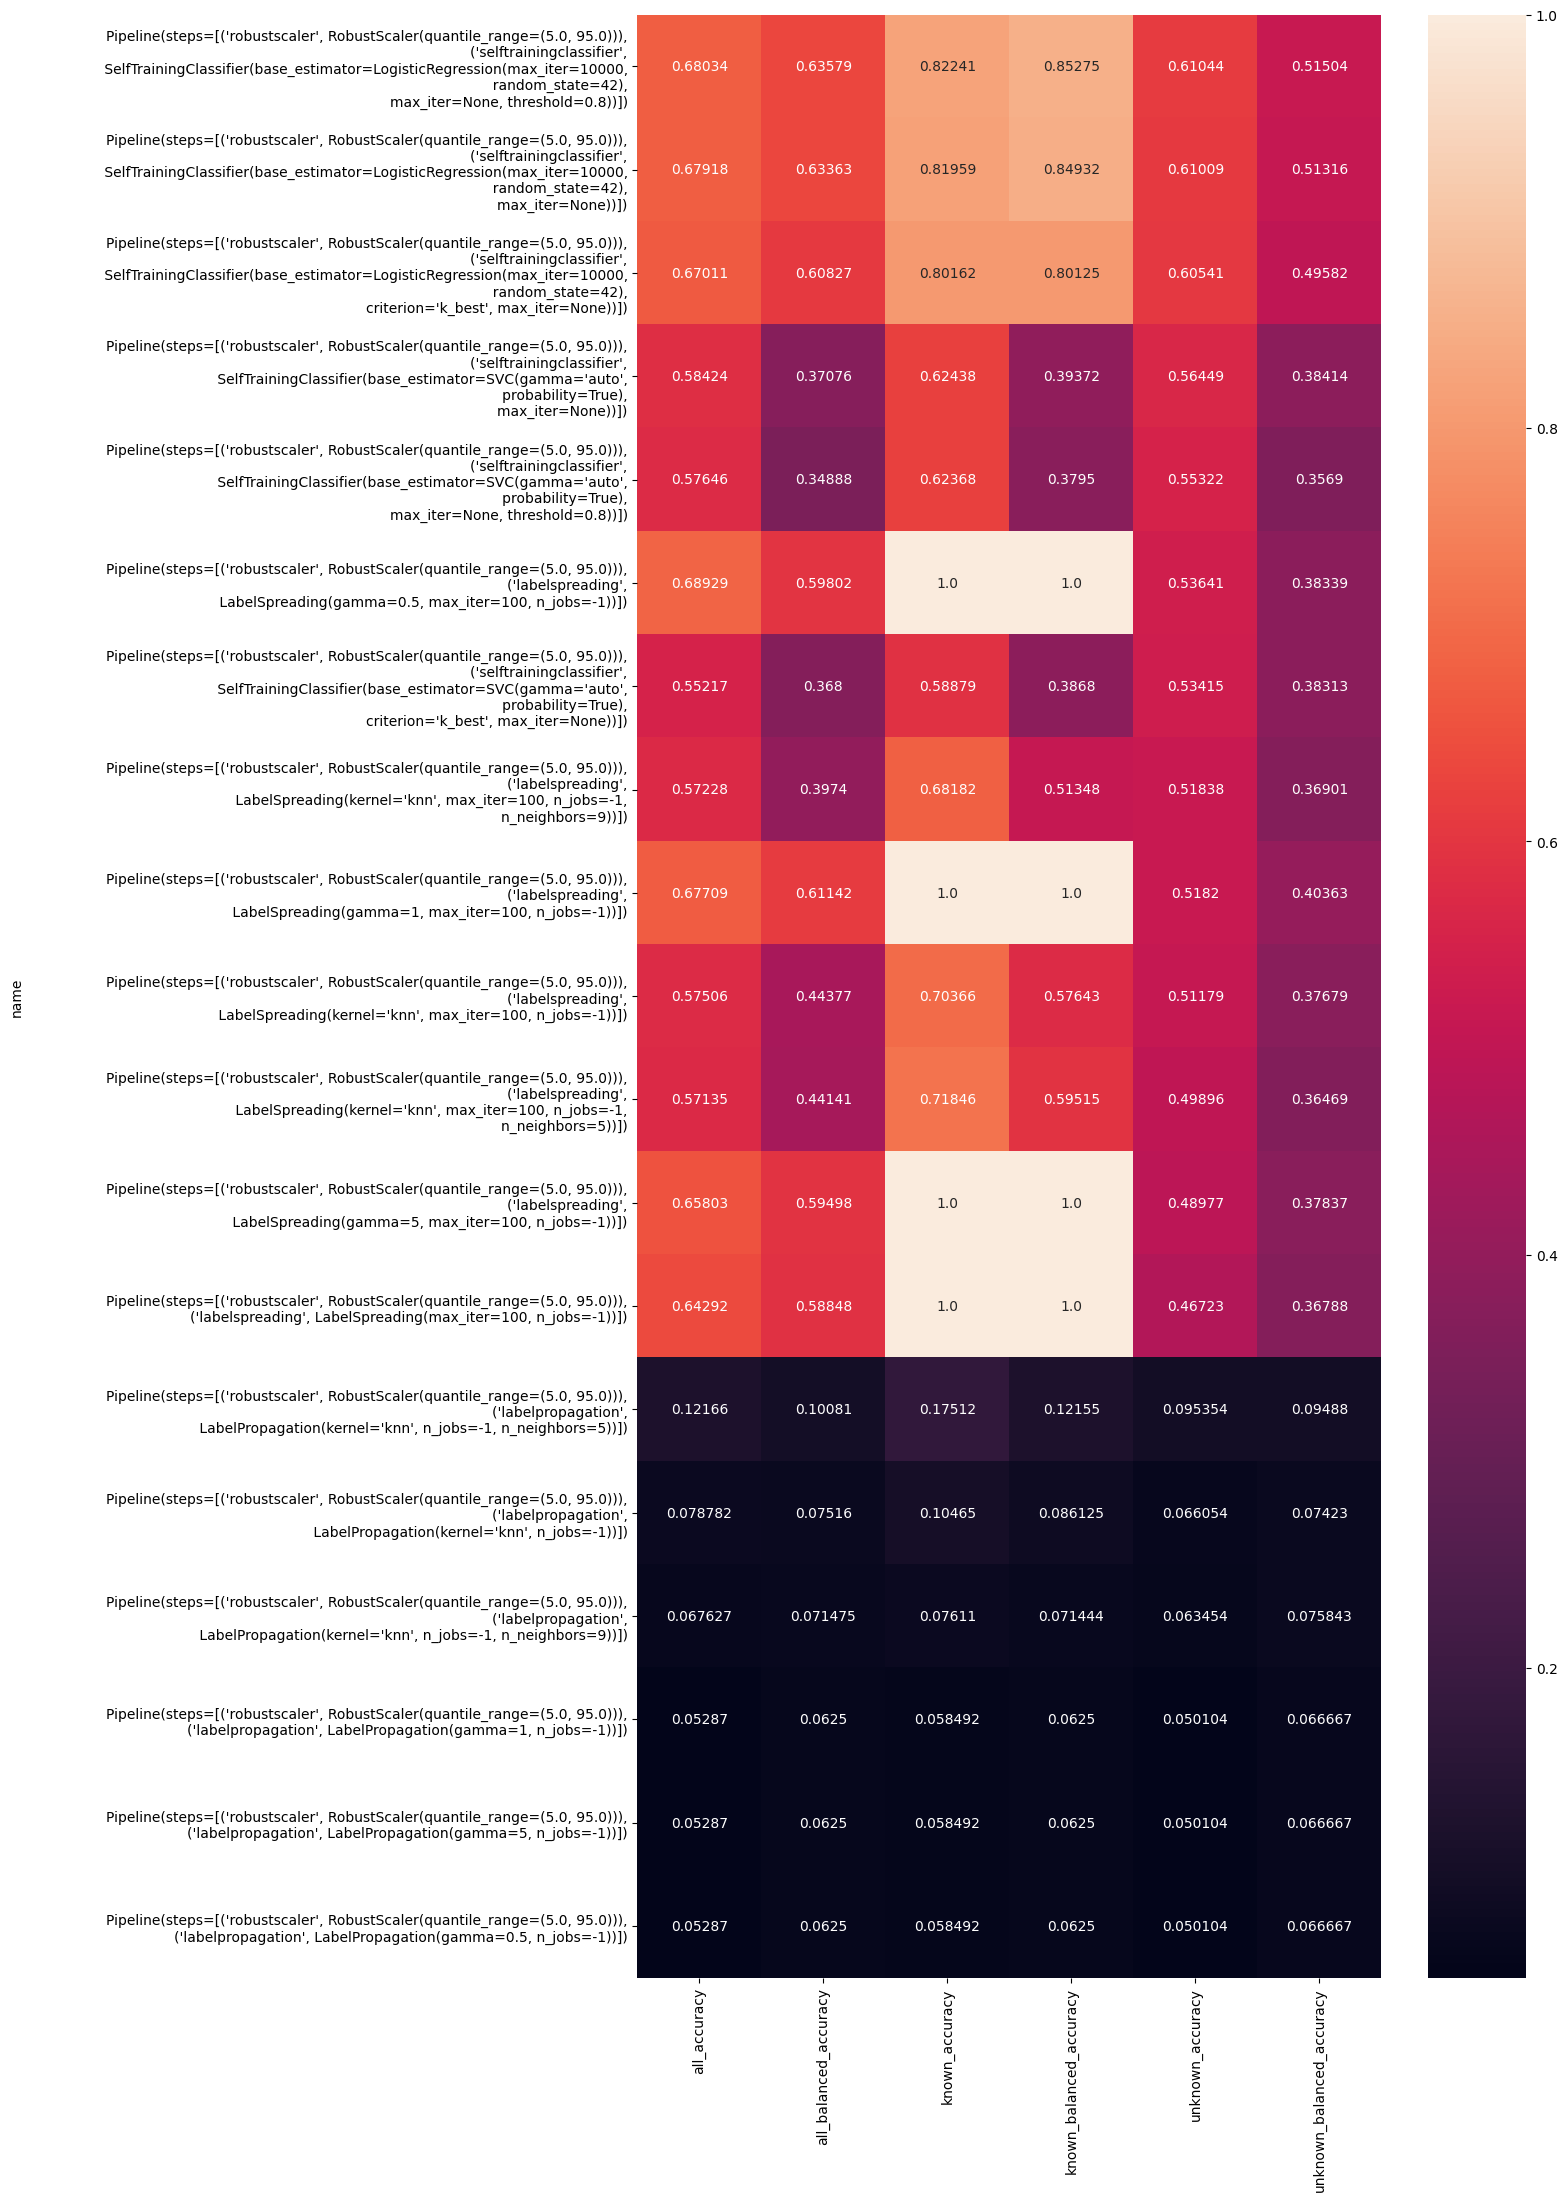

In [20]:
plt.figure(figsize=(12, 26), dpi=100)
sns.heatmap(scores_df, annot=True, fmt='.5')

## Voting clf
Przeczytać jakie są defaulty: http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/#example-5-using-pre-fitted-classifiers

In [21]:
best_clfs = [joblib.hash(c)+'.pkl' for c in scores_df.index[[0,5]].tolist() + [scores_lr_df.index[0]]]
best_clfs = [joblib.load(clf_dir / path) for path in best_clfs]
best_clfs

[Pipeline(steps=[('robustscaler', RobustScaler(quantile_range=(5.0, 95.0))),
                 ('selftrainingclassifier',
                  SelfTrainingClassifier(base_estimator=LogisticRegression(max_iter=10000,
                                                                           random_state=42),
                                         max_iter=None, threshold=0.8))]),
 Pipeline(steps=[('robustscaler', RobustScaler(quantile_range=(5.0, 95.0))),
                 ('labelspreading',
                  LabelSpreading(gamma=0.5, max_iter=100, n_jobs=-1))]),
 Pipeline(steps=[('robustscaler', RobustScaler(quantile_range=(5.0, 95.0))),
                 ('logisticregression',
                  LogisticRegression(max_iter=10000, random_state=42))])]

In [22]:
eclf = EnsembleVoteClassifier(clfs=best_clfs, fit_base_estimators=False)
eclf_score = fit_score(eclf, X_df, y_df)

In [23]:
eclf_df = pd.DataFrame.from_records([eclf_score]).set_index('name').sort_values('unknown_accuracy', ascending=False)
eclf_df

,all_accuracy,all_balanced_accuracy,known_accuracy,known_balanced_accuracy,unknown_accuracy,unknown_balanced_accuracy
name,,,,,,
"EnsembleVoteClassifier(clfs=[Pipeline(steps=[('robustscaler',\n RobustScaler(quantile_range=(5.0,\n 95.0))),\n ('selftrainingclassifier',\n SelfTrainingClassifier(base_estimator=LogisticRegression(max_iter=10000,\n random_state=42),\n max_iter=None,\n threshold=0.8))]),\n Pipeline(steps=[('robustscaler',\n RobustScaler(quantile_range=(5.0,\n 95.0))),\n ('labelspreading',\n LabelSpreading(gamma=0.5,\n max_iter=100,\n n_jobs=-1))]),\n Pipeline(steps=[('robustscaler',\n RobustScaler(quantile_range=(5.0,\n 95.0))),\n ('logisticregression',\n LogisticRegression(max_iter=10000,\n random_state=42))])],\n fit_base_estimators=False, use_clones=False)",0.686265,0.642333,0.840381,0.877258,0.610437,0.514218


## R... er, scrach that

Niestety R zawiódł, ponieważ biblioteka RSSL do uczenia półnadzorowanego nie działa w przypadku klasyfikacji wieloklasowej. Możliwe, że dałoby się to obejść metodą OvR, ale jest to metoda do uczenia nadzorowanego (a nie półnadzrowanego), a pozatym raczej klasyfikatory z RSSL nie zwracają oceny pewności wykonanej predykcji.

```{R}
library(RSSL)
library(dplyr)
library(ggplot2)
library(tidyr)

set.seed(1)
df <- read.csv("data/R_chkp4.csv") %>%
  mutate_at('Class', as.factor)
df2<- df_orig %>% add_missinglabels_mar(Class~.,0.95)
g_s4 <- S4VM(Class~.,df,C1=1,C2=0.1,lambda_tradeoff = 3,scale=TRUE,x_center=TRUE)
```